## The Battle of the Neighborhoods - Week 2

#### Introduction

In this section of the capstone project, we will use the Foursquare API to explore neighborhoods in Toronto City. We will use the explore function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. We will use the k-means clustering algorithm to complete this task. Finally, we will use the Folium library to visualize the neighborhoods in Toronto City and their emerging clusters.

### Table of Contents
1. Download and Explore Dataset
2. Explore Neighborhoods in Toronto City
3. Analyze Each Neighborhood
4. Cluster Neighborhoods and Examine Clusters

#### Download all the dependent libraries for the code.

In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import matplotlib.pyplot as plt

#### 1. Download and Explore Dataset

We will download the dataset for Toronto city from the below link and the neighborhoods that exist in each borough as well as the latitude and logitude coordinates of each neighborhood. 

#### Load and explore the data

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(url)
html_doc = response.text

In [3]:
soup = BeautifulSoup(html_doc, 'html.parser')

#### Retrieve the Borough and Neighbourhood data from HTML table 

In [4]:
table = soup.find_all('table')[0]

In [5]:
tr_values = table.find_all('tr')

th_values = tr_values[0].find_all('th')


header_columns=[]

for thvalue in th_values:
    header_columns.append(thvalue.contents[0].replace('\n',''))

header_columns

['Postcode', 'Borough', 'Neighbourhood']

In [6]:
toronto_df = pd.DataFrame(columns=header_columns)
toronto_df

Empty DataFrame
Columns: [Postcode, Borough, Neighbourhood]
Index: []

#### Retrieving the Neighborhood data and loading them to dataframe.

In [7]:
# Delete all rows in the dataframe before loading the records
toronto_df = toronto_df[0:0]

# Loop through each row 
for trvalue in tr_values:
    
# Retrieve the column information    
    td_values = trvalue.find_all('td')
    if len(td_values) > 0 :
        tdlist = []
        
# Loop through each column, clean the data and load them into the dataframe        
        for tdvalue in td_values:
            if len(tdvalue.find_all('a')) > 0 :
                link = tdvalue.find('a')
                tdlist.append(link.get('title').replace('\n','').replace('(Toronto)','').replace(', Toronto',''))
            else:    
                tdlist.append(tdvalue.contents[0].replace('\n','').replace('(Toronto)','').replace(', Toronto',''))  
                
# Replace Neighbourhood column with Borough value when Neighbourhood = 'Not assigned'
        if tdlist[2] == 'Not assigned':
            tdlist[2] = tdlist[1]
# Load the data into dataframe only when Borough is not 'Not assigned'            
        if tdlist[1] != 'Not assigned':
            toronto_df = toronto_df.append(pd.Series(tdlist, index=toronto_df.columns ), ignore_index=True)
        
toronto_df.head()


Postcode           Borough     Neighbourhood
0      M3A        North York         Parkwoods
1      M4A        North York  Victoria Village
2      M5A  Downtown Toronto     Harbourfront 
3      M5A  Downtown Toronto       Regent Park
4      M6A        North York  Lawrence Heights

In [10]:
toronto_df = toronto_df_merge.groupby(['Postcode','Borough']).agg({'Neighbourhood' : ','.join}).reset_index().reindex(columns=toronto_df.columns)

toronto_df.head()

Postcode      Borough                          Neighbourhood
0      M1B  Scarborough                          Rouge,Malvern
1      M1C  Scarborough  Highland Creek ,Rouge Hill,Port Union
2      M1E  Scarborough        Guildwood,Morningside,West Hill
3      M1G  Scarborough                                 Woburn
4      M1H  Scarborough                              Cedarbrae

#### Retrieving Geospatial Coordinates for Toronto City from the CSV file and load them to Dataframes

In [11]:
geo_df = pd.read_csv('Geospatial_Coordinates.csv')
geo_df.columns = ['Postcode','Latitude','Longitude']
geo_df.head()

Postcode   Latitude  Longitude
0      M1B  43.806686 -79.194353
1      M1C  43.784535 -79.160497
2      M1E  43.763573 -79.188711
3      M1G  43.770992 -79.216917
4      M1H  43.773136 -79.239476

In [12]:
toronto_geo_df = pd.merge(toronto_df,geo_df,on='Postcode')
toronto_geo_df.head()

Postcode      Borough                          Neighbourhood   Latitude  \
0      M1B  Scarborough                          Rouge,Malvern  43.806686   
1      M1C  Scarborough  Highland Creek ,Rouge Hill,Port Union  43.784535   
2      M1E  Scarborough        Guildwood,Morningside,West Hill  43.763573   
3      M1G  Scarborough                                 Woburn  43.770992   
4      M1H  Scarborough                              Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [13]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


### Create a map of Toronto with neighborhoods superimposed on top.

__Folium__ is a great visualization library. We can zoom into the below map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

In [14]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_geo_df['Latitude'], toronto_geo_df['Longitude'], toronto_geo_df['Borough'], toronto_geo_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

#### Retrieving Demographics information from CSV file and load them to dataframe.

In [16]:
demo_df = pd.read_csv('Toronto-Demographics.csv',index_col=0)
#demo_df.columns = ['Postcode','Latitude','Longitude']
demo_df.head()

2016      2011      2006      2001      1996
Ethnic Origins                                                
Canadian        746960  728745.0  651635.0  861945.0  710755.0
English         732555  777110.0  804100.0  783770.0  891735.0
Chinese         700705  594735.0  537060.0  435685.0  359450.0
Indian          643370  572250.0  484655.0  345855.0  255685.0
Irish           544380  543600.0  531865.0  487215.0  480980.0

#### Plot the population growth over the years using line chart

([<matplotlib.axis.XTick at 0x2c7c3f73048>,
 <a list of 5 Text xticklabel objects>)

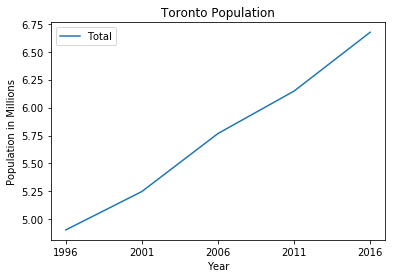

In [17]:
can_df = pd.DataFrame(demo_df.sum(axis=0,skipna=True))
can_df = can_df / 1000000
can_df.reset_index(inplace=True)

can_df.columns = ['Year','Total']
can_df['Year'] = can_df['Year'].astype('int')
can_df = can_df.sort_values(by=['Year'],ascending=True)
can_df

can_df.plot(kind='line',x='Year',y='Total')
plt.ylabel('Population in Millions')
plt.title('Toronto Population')
plt.xticks([1996,2001,2006,2011,2016])

#### Define Foursquare Credentials and Version

In [18]:
CLIENT_ID = 'NLEJBMPHYJVML13NCKHMJU5FBAYQWRS0X4RFSINGNP1HDWHU' # your Foursquare ID
CLIENT_SECRET = 'H0SF4IEDPTD2QF2UPEI0A2DP4KW3LMUH4WX4TFH5NVYHYWQT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NLEJBMPHYJVML13NCKHMJU5FBAYQWRS0X4RFSINGNP1HDWHU
CLIENT_SECRET:H0SF4IEDPTD2QF2UPEI0A2DP4KW3LMUH4WX4TFH5NVYHYWQT


### Filtering only neighborhoods under Toronto Boroughs

In [20]:
toronto_neigh_df = toronto_geo_df[toronto_geo_df['Borough'].str.contains('Toronto')]
toronto_neigh_df.reset_index(drop=True,inplace=True)
toronto_neigh_df

Postcode           Borough  \
0       M4E      East Toronto   
1       M4K      East Toronto   
2       M4L      East Toronto   
3       M4M      East Toronto   
4       M4N   Central Toronto   
5       M4P   Central Toronto   
6       M4R   Central Toronto   
7       M4S   Central Toronto   
8       M4T   Central Toronto   
9       M4V   Central Toronto   
10      M4W  Downtown Toronto   
11      M4X  Downtown Toronto   
12      M4Y  Downtown Toronto   
13      M5A  Downtown Toronto   
14      M5B  Downtown Toronto   
15      M5C  Downtown Toronto   
16      M5E  Downtown Toronto   
17      M5G  Downtown Toronto   
18      M5H  Downtown Toronto   
19      M5J  Downtown Toronto   
20      M5K  Downtown Toronto   
21      M5L  Downtown Toronto   
22      M5N   Central Toronto   
23      M5P   Central Toronto   
24      M5R   Central Toronto   
25      M5S  Downtown Toronto   
26      M5T  Downtown Toronto   
27      M5V  Downtown Toronto   
28      M5W  Downtown Toronto   
29      M5X  Downtown Toronto   
30      M6G  Downtown Toronto   
31      M6H      West Toronto   
32      M6J      West Toronto   
33      M6K      West Toronto   
34      M6P      West Toronto   
35      M6R      West Toronto   
36      M6S      West Toronto   
37      M7Y      East Toronto   

                                        Neighbourhood   Latitude  Longitude  
0                                         The Beaches  43.676357 -79.293031  
1                         The Danforth West,Riverdale  43.679557 -79.352188  
2                       The Beaches West,India Bazaar  43.668999 -79.315572  
3                                     Studio District  43.659526 -79.340923  
4                                       Lawrence Park  43.728020 -79.388790  
5                                    Davisville North  43.712751 -79.390197  
6                                  North Toronto West  43.715383 -79.405678  
7                                          Davisville  43.704324 -79.388790  
8                          Moore Park,Summerhill East  43.689574 -79.383160  
9   Deer Park,Forest Hill SE,Rathnelly,South Hill,...  43.686412 -79.400049  
10                                           Rosedale  43.679563 -79.377529  
11                         Cabbagetown,St. James Town  43.667967 -79.367675  
12                               Church and Wellesley  43.665860 -79.383160  
13                          Harbourfront ,Regent Park  43.654260 -79.360636  
14                            Ryerson,Garden District  43.657162 -79.378937  
15                                     St. James Town  43.651494 -79.375418  
16                                        Berczy Park  43.644771 -79.373306  
17                                 Central Bay Street  43.657952 -79.387383  
18                             Adelaide,King,Richmond  43.650571 -79.384568  
19   Harbourfront East,Toronto Islands,Union Station   43.640816 -79.381752  
20            Design Exchange,Toronto Dominion Centre  43.647177 -79.381576  
21                      Commerce Court,Victoria Hotel  43.648198 -79.379817  
22                                           Roselawn  43.711695 -79.416936  
23                 Forest Hill North,Forest Hill West  43.696948 -79.411307  
24                  The Annex,North Midtown,Yorkville  43.672710 -79.405678  
25                      Harbord,University of Toronto  43.662696 -79.400049  
26           Chinatown,Grange Park ,Kensington Market  43.653206 -79.400049  
27  CN Tower,Bathurst Quay,Island airport,Harbourf...  43.628947 -79.394420  
28                    Stn A PO Boxes 25 The Esplanade  43.646435 -79.374846  
29              First Canadian Place,Underground city  43.648429 -79.382280  
30                                           Christie  43.669542 -79.422564  
31                        Dovercourt Village,Dufferin  43.669005 -79.442259  
32                  Little Portugal,Trinity–Bellwoods  43.647927 -79.419750  
33         Brockton,Exhibition Place,Parkdale Village  43.63684

#### Using Foursquare API retrieving Venue informaton for each neighborhood in Toronto 

In [256]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [257]:
LIMIT = 100
radius = 500

toronto_venues = getNearbyVenues(names=toronto_neigh_df['Neighbourhood'],
                                   latitudes=toronto_neigh_df['Latitude'],
                                   longitudes=toronto_neigh_df['Longitude']
                                  )

print(toronto_venues.shape)
toronto_venues.head()

(1703, 7)


Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0   The Beaches               43.676357               -79.293031   
1   The Beaches               43.676357               -79.293031   
2   The Beaches               43.676357               -79.293031   
3   The Beaches               43.676357               -79.293031   
4   The Beaches               43.676357               -79.293031   

                                Venue  Venue Latitude  Venue Longitude  \
0  The Big Carrot Natural Food Market       43.678879       -79.297734   
1                 Grover Pub and Grub       43.679181       -79.297215   
2                           Starbucks       43.678798       -79.298045   
3                   Glen Stewart Park       43.675278       -79.294647   
4                       Upper Beaches       43.680563       -79.292869   

      Venue Category  
0  Health Food Store  
1                Pub  
2        Coffee Shop  
3               Park  
4       Neighborhood

In [258]:
toronto_venues = toronto_venues.join(toronto_neigh_df[['Borough','Neighbourhood']].set_index('Neighbourhood'), on='Neighbourhood')
toronto_venues.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0   The Beaches               43.676357               -79.293031   
1   The Beaches               43.676357               -79.293031   
2   The Beaches               43.676357               -79.293031   
3   The Beaches               43.676357               -79.293031   
4   The Beaches               43.676357               -79.293031   

                                Venue  Venue Latitude  Venue Longitude  \
0  The Big Carrot Natural Food Market       43.678879       -79.297734   
1                 Grover Pub and Grub       43.679181       -79.297215   
2                           Starbucks       43.678798       -79.298045   
3                   Glen Stewart Park       43.675278       -79.294647   
4                       Upper Beaches       43.680563       -79.292869   

      Venue Category       Borough  
0  Health Food Store  East Toronto  
1                Pub  East Toronto  
2        Coffee Shop  East Toronto  
3               Park  East Toronto  
4       Neighborhood  East Toronto

In [259]:
toronto_venues.groupby('Neighbourhood').count()

Neighbourhood Latitude  \
Neighbourhood                                                                
Adelaide,King,Richmond                                                 100   
Berczy Park                                                             56   
Brockton,Exhibition Place,Parkdale Village                              21   
Business Reply Mail Processing Centre 969 Eastern                       19   
CN Tower,Bathurst Quay,Island airport,Harbourfr...                      15   
Cabbagetown,St. James Town                                              48   
Central Bay Street                                                      84   
Chinatown,Grange Park ,Kensington Market                               100   
Christie                                                                15   
Church and Wellesley                                                    85   
Commerce Court,Victoria Hotel                                          100   
Davisville                                                              35   
Davisville North                                                         8   
Deer Park,Forest Hill SE,Rathnelly,South Hill,S...                      14   
Design Exchange,Toronto Dominion Centre                                100   
Dovercourt Village,Dufferin                                             20   
First Canadian Place,Underground city                                  100   
Forest Hill North,Forest Hill West                                       4   
Harbord,University of Toronto                                           34   
Harbourfront ,Regent Park                                               48   
Harbourfront East,Toronto Islands,Union Station                        100   
High Park,The Junction South                                            24   
Lawrence Park                                                            3   
Little Portugal,Trinity–Bellwoods                                       62   
Moore Park,Summerhill East                                               4   
North Toronto West                                                      21   
Parkdale,Roncesvalles                                                   16   
Rosedale                                                                 4   
Roselawn                                                                 2   
Runnymede,Swansea                                                       37   
Ryerson,Garden District                                                100   
St. James Town                                                         100   
Stn A PO Boxes 25 The Esplanade                                         95   
Studio District                                                         37   
The Annex,North Midtown,Yorkville                                       24   
The Beaches                                                              5   
The Beaches West,India Bazaar                                           19   
The Danforth West,Riverdale                                             44   

                                                    Neighbourhood Longitude  \
Neighbourhood                                                                 
Adelaide,King,Richmond                                                  100   
Berczy Park                                                              56   
Brockton,Exhibition Place,Parkdale Village                               21   
Business Reply Mail Processing Centre 969 Eastern                        19   
CN Tower,Bathurst Quay,Island airport,Harbourfr...                       15   
Cabbagetown,St. James Town                                               48   
Central Bay Street                                                       84   
Chinatown,Grange Park ,Kensington Market                                100   
Christie                                                                 15   
Church and Wellesley                                          

In [260]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 238 uniques categories.


### Downtown Toronto - Venues Visualization

In [118]:
toronto_downtown_venues = toronto_venues[toronto_venues['Borough'] == 'Downtown Toronto']
print(toronto_downtown_venues.shape)

(1284, 8)


In [119]:
print('There are {} uniques categories.'.format(len(toronto_downtown_venues['Venue Category'].unique())))
print('There are {} uniques Venues.'.format(len(toronto_downtown_venues['Venue'].unique())))

There are 204 uniques categories.
There are 749 uniques Venues.


In [121]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_downtown_venues['Venue Latitude'], toronto_downtown_venues['Venue Longitude'], toronto_downtown_venues['Neighbourhood'], toronto_downtown_venues['Venue Category']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

### East Toronto Venues Visualization

In [116]:
toronto_east_venues = toronto_venues[toronto_venues['Borough'] == 'East Toronto']
print(toronto_east_venues.shape)

(124, 8)


In [117]:
print('There are {} uniques categories.'.format(len(toronto_east_venues['Venue Category'].unique())))
print('There are {} uniques Venues.'.format(len(toronto_east_venues['Venue'].unique())))

There are 68 uniques categories.
There are 121 uniques Venues.


In [229]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_east_venues['Venue Latitude'], toronto_east_venues['Venue Longitude'], toronto_east_venues['Neighbourhood'], toronto_east_venues['Venue Category']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

### Central Toronto Venue Visualization

In [123]:
toronto_central_venues = toronto_venues[toronto_venues['Borough'] == 'Central Toronto']
print(toronto_central_venues.shape)

(115, 8)


In [124]:
print('There are {} uniques categories.'.format(len(toronto_central_venues['Venue Category'].unique())))
print('There are {} uniques Venues.'.format(len(toronto_central_venues['Venue'].unique())))

There are 64 uniques categories.
There are 102 uniques Venues.


In [125]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_central_venues['Venue Latitude'], toronto_central_venues['Venue Longitude'], toronto_central_venues['Neighbourhood'], toronto_central_venues['Venue Category']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

### West Toronto Venue Visualization

In [129]:
toronto_west_venues = toronto_venues[toronto_venues['Borough'] == 'West Toronto']
print(toronto_west_venues.shape)

(180, 8)


In [130]:
print('There are {} uniques categories.'.format(len(toronto_west_venues['Venue Category'].unique())))
print('There are {} uniques Venues.'.format(len(toronto_west_venues['Venue'].unique())))

There are 90 uniques categories.
There are 176 uniques Venues.


In [255]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_west_venues['Venue Latitude'], toronto_west_venues['Venue Longitude'], toronto_west_venues['Neighbourhood'], toronto_west_venues['Venue Category']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

In [261]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

toronto_onehot

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

Neighbourhood  Adult Boutique  Afghan Restaurant  Airport  \
0   The Beaches               0                  0        0   
1   The Beaches               0                  0        0   
2   The Beaches               0                  0        0   
3   The Beaches               0                  0        0   
4   The Beaches               0                  0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant     ...       Trail  Train Station  \
0                 0                    0     ...           0              0   
1                 0                    0     ...           0              0   
2                 0                    0     ...           0              0   
3                 0                    0     ...           0              0   
4                 0                    0     ...           0              0   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                              0                 0            0   
1                              0                 0            0   
2                              0                 0            0   
3                              0                 0            0   
4                              0                 0            0   

   Vietnamese Restaurant  Wine Bar  Wine Shop  Wings Joint  Yoga Studio  
0                      0         0          0            0            0  
1                      0         0          0            0            0  
2                      0         0          0            0            0  
3                      0         0          0            0            0  
4                      0         0          0            0            0  

[5 rows x 239 columns]

#### Filtering only restaurant venue cateogories for further analysis

In [262]:
restaurant_List = []
search = 'Restaurant'
for i in toronto_onehot.columns :
    if search in i:
        restaurant_List.append(i)
restaurant_List

['Afghan Restaurant',
 'American Restaurant',
 'Argentinian Restaurant',
 'Asian Restaurant',
 'Belgian Restaurant',
 'Brazilian Restaurant',
 'Cajun / Creole Restaurant',
 'Caribbean Restaurant',
 'Chinese Restaurant',
 'Colombian Restaurant',
 'Comfort Food Restaurant',
 'Cuban Restaurant',
 'Dim Sum Restaurant',
 'Doner Restaurant',
 'Dumpling Restaurant',
 'Eastern European Restaurant',
 'Ethiopian Restaurant',
 'Falafel Restaurant',
 'Fast Food Restaurant',
 'Filipino Restaurant',
 'French Restaurant',
 'German Restaurant',
 'Gluten-free Restaurant',
 'Greek Restaurant',
 'Indian Restaurant',
 'Italian Restaurant',
 'Japanese Restaurant',
 'Jewish Restaurant',
 'Korean Restaurant',
 'Latin American Restaurant',
 'Malay Restaurant',
 'Mediterranean Restaurant',
 'Mexican Restaurant',
 'Middle Eastern Restaurant',
 'Modern European Restaurant',
 'Molecular Gastronomy Restaurant',
 'New American Restaurant',
 'Portuguese Restaurant',
 'Ramen Restaurant',
 'Restaurant',
 'Seafood Rest

In [263]:
col_name = []
col_name = ['Neighbourhood'] + restaurant_List
toronto_restaurant = toronto_onehot[col_name]
#toronto_restaurant = toronto_restaurant.iloc[:,1::]
toronto_restaurant.head()

Neighbourhood  Afghan Restaurant  American Restaurant  \
0   The Beaches                  0                    0   
1   The Beaches                  0                    0   
2   The Beaches                  0                    0   
3   The Beaches                  0                    0   
4   The Beaches                  0                    0   

   Argentinian Restaurant  Asian Restaurant  Belgian Restaurant  \
0                       0                 0                   0   
1                       0                 0                   0   
2                       0                 0                   0   
3                       0                 0                   0   
4                       0                 0                   0   

   Brazilian Restaurant  Cajun / Creole Restaurant  Caribbean Restaurant  \
0                     0                          0                     0   
1                     0                          0                     0   
2                     0                          0                     0   
3                     0                          0                     0   
4                     0                          0                     0   

   Chinese Restaurant          ...            Restaurant  Seafood Restaurant  \
0                   0          ...                     0                   0   
1                   0          ...                     0                   0   
2                   0          ...                     0                   0   
3                   0          ...                     0                   0   
4                   0          ...                     0                   0   

   Southern / Soul Food Restaurant  Sushi Restaurant  Taiwanese Restaurant  \
0                                0                 0                     0   
1                                0                 0                     0   
2                                0                 0                     0   
3                                0                 0                     0   
4                                0                 0                     0   

   Tapas Restaurant  Thai Restaurant  Theme Restaurant  \
0                 0                0                 0   
1                 0                0                 0   
2                 0                0                 0   
3                 0                0                 0   
4                 0                0                 0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  
0                              0                      0  
1                              0                      0  
2                              0                      0  
3                              0                      0  
4                              0                      0  

[5 rows x 50 columns]

In [265]:
toronto_restaurant_grouped = toronto_restaurant.groupby('Neighbourhood').sum().reset_index()
toronto_restaurant_grouped.head()

Neighbourhood  Afghan Restaurant  \
0                             Adelaide,King,Richmond                  0   
1                                        Berczy Park                  0   
2         Brockton,Exhibition Place,Parkdale Village                  0   
3  Business Reply Mail Processing Centre 969 Eastern                  0   
4  CN Tower,Bathurst Quay,Island airport,Harbourf...                  0   

   American Restaurant  Argentinian Restaurant  Asian Restaurant  \
0                    4                       0                 2   
1                    0                       0                 0   
2                    0                       0                 0   
3                    0                       0                 0   
4                    0                       0                 0   

   Belgian Restaurant  Brazilian Restaurant  Cajun / Creole Restaurant  \
0                   0                     1                          0   
1                   1                     0                          0   
2                   0                     0                          0   
3                   0                     0                          0   
4                   0                     0                          0   

   Caribbean Restaurant  Chinese Restaurant          ...            \
0                     0                   0          ...             
1                     0                   0          ...             
2                     1                   0          ...             
3                     0                   0          ...             
4                     0                   0          ...             

   Restaurant  Seafood Restaurant  Southern / Soul Food Restaurant  \
0           3                   1                                0   
1           2                   2                                0   
2           1                   0                                0   
3           1                   0                                0   
4           0                   0                                0   

   Sushi Restaurant  Taiwanese Restaurant  Tapas Restaurant  Thai Restaurant  \
0                 3                     0                 0                4   
1                 0                     0                 0                1   
2                 0                     0                 0                0   
3                 0                     0                 0                0   
4                 0                     0                 0                0   

   Theme Restaurant  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  
0                 0                              1                      0  
1                 0                              1                      0  
2                 0                              0                      0  
3                 0                              0                      0  
4                 0                              0                      0  

[5 rows x 50 columns]

In [266]:
toronto_restaurant_grouped['Total'] = toronto_restaurant_grouped.sum(axis=1)

In [267]:
toronto_res_borough = toronto_restaurant.join(toronto_neigh_df[['Neighbourhood','Borough']].set_index('Neighbourhood'), on='Neighbourhood')
toronto_res_mean_group = toronto_res_borough.groupby('Borough').mean().reset_index()
toronto_res_mean_group

Borough  Afghan Restaurant  American Restaurant  \
0   Central Toronto           0.000000             0.017391   
1  Downtown Toronto           0.000779             0.017134   
2      East Toronto           0.000000             0.024194   
3      West Toronto           0.000000             0.000000   

   Argentinian Restaurant  Asian Restaurant  Belgian Restaurant  \
0                0.000000          0.000000            0.000000   
1                0.000000          0.003894            0.002336   
2                0.000000          0.000000            0.000000   
3                0.005556          0.016667            0.000000   

   Brazilian Restaurant  Cajun / Creole Restaurant  Caribbean Restaurant  \
0              0.000000                   0.000000              0.000000   
1              0.001558                   0.000000              0.003894   
2              0.000000                   0.000000              0.008065   
3              0.005556                   0.005556              0.005556   

   Chinese Restaurant          ...            Restaurant  Seafood Restaurant  \
0            0.008696          ...              0.026087            0.008696   
1            0.007788          ...              0.032710            0.016355   
2            0.008065          ...              0.016129            0.008065   
3            0.000000          ...              0.027778            0.000000   

   Southern / Soul Food Restaurant  Sushi Restaurant  Taiwanese Restaurant  \
0                         0.000000          0.034783              0.000000   
1                         0.000000          0.010125              0.000779   
2                         0.000000          0.016129              0.000000   
3                         0.005556          0.011111              0.000000   

   Tapas Restaurant  Thai Restaurant  Theme Restaurant  \
0          0.000000         0.008696          0.000000   
1          0.000000         0.014798          0.000779   
2          0.000000         0.000000          0.000000   
3          0.005556         0.005556          0.000000   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  
0                       0.008696               0.008696  
1                       0.012461               0.004673  
2                       0.000000               0.000000  
3                       0.011111               0.011111  

[4 rows x 50 columns]

In [268]:
toronto_res_sum_group = toronto_res_borough.groupby('Borough').sum().reset_index()
toronto_res_sum_group

Borough  Afghan Restaurant  American Restaurant  \
0   Central Toronto                  0                    2   
1  Downtown Toronto                  1                   22   
2      East Toronto                  0                    3   
3      West Toronto                  0                    0   

   Argentinian Restaurant  Asian Restaurant  Belgian Restaurant  \
0                       0                 0                   0   
1                       0                 5                   3   
2                       0                 0                   0   
3                       1                 3                   0   

   Brazilian Restaurant  Cajun / Creole Restaurant  Caribbean Restaurant  \
0                     0                          0                     0   
1                     2                          0                     5   
2                     0                          0                     1   
3                     1                          1                     1   

   Chinese Restaurant          ...            Restaurant  Seafood Restaurant  \
0                   1          ...                     3                   1   
1                  10          ...                    42                  21   
2                   1          ...                     2                   1   
3                   0          ...                     5                   0   

   Southern / Soul Food Restaurant  Sushi Restaurant  Taiwanese Restaurant  \
0                                0                 4                     0   
1                                0                13                     1   
2                                0                 2                     0   
3                                1                 2                     0   

   Tapas Restaurant  Thai Restaurant  Theme Restaurant  \
0                 0                1                 0   
1                 0               19                 1   
2                 0                0                 0   
3                 1                1                 0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  
0                              1                      1  
1                             16                      6  
2                              0                      0  
3                              2                      2  

[4 rows x 50 columns]

In [181]:
toronto_res_sum_group.set_index('Borough',inplace=True)
#toronto_res_sum_group.columns = ['Central Toronto','Downtown Toronto','East Toronto','West Toronto']
print(toronto_res_sum_group.shape)
toronto_res_sum_group = toronto_res_sum_group.transpose()

(4, 49)


Borough              Central Toronto  Downtown Toronto  East Toronto  \
Sushi Restaurant                   4                13             2   
Restaurant                         3                42             2   
American Restaurant                2                22             3   

Borough              West Toronto  
Sushi Restaurant                2  
Restaurant                      5  
American Restaurant             0

### Top 5 restaurants in Central Toronto

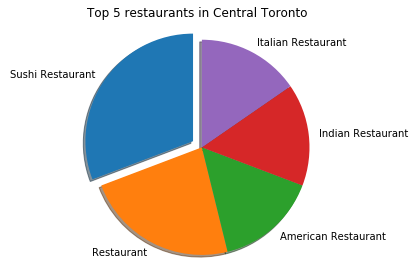

In [202]:
ctoronto_top_5 = pd.DataFrame(toronto_res_sum_group.nlargest(5, 'Central Toronto')['Central Toronto'])
ctoronto_top_5.reset_index(level=0, inplace=True)
import matplotlib.pyplot as plt

explode = (0.1,0, 0, 0,0)
patches, texts = plt.pie(ctoronto_top_5['Central Toronto'],labels=ctoronto_top_5['index'],explode=explode,shadow=True, startangle=90)
plt.axis('equal')
plt.title('Top 5 restaurants in Central Toronto')
plt.tight_layout()
plt.show()

### Top 5 restaurants in Downtown Toronto

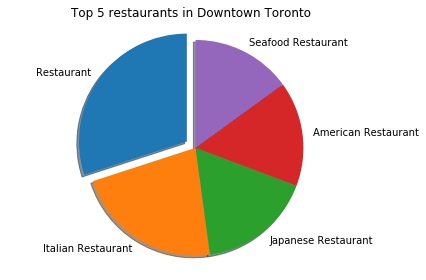

In [203]:
dtoronto_top_5 = pd.DataFrame(toronto_res_sum_group.nlargest(5, 'Downtown Toronto')['Downtown Toronto'])
dtoronto_top_5.reset_index(level=0, inplace=True)
import matplotlib.pyplot as plt

explode = (0.1,0, 0, 0,0)
patches, texts = plt.pie(dtoronto_top_5['Downtown Toronto'],labels=dtoronto_top_5['index'],explode=explode,shadow=True, startangle=90)
plt.axis('equal')
plt.title('Top 5 restaurants in Downtown Toronto')
plt.tight_layout()
plt.show()

### Top 5 restaurants in East Toronto

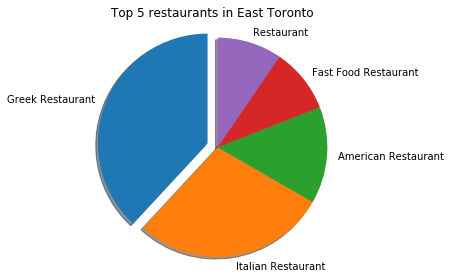

In [204]:
etoronto_top_5 = pd.DataFrame(toronto_res_sum_group.nlargest(5, 'East Toronto')['East Toronto'])
etoronto_top_5.reset_index(level=0, inplace=True)
import matplotlib.pyplot as plt

explode = (0.1,0, 0, 0,0)
patches, texts = plt.pie(etoronto_top_5['East Toronto'],labels=etoronto_top_5['index'],explode=explode,shadow=True, startangle=90)
plt.axis('equal')
plt.title('Top 5 restaurants in East Toronto')
plt.tight_layout()
plt.show()

### Top 5 restaurants in West Toronto

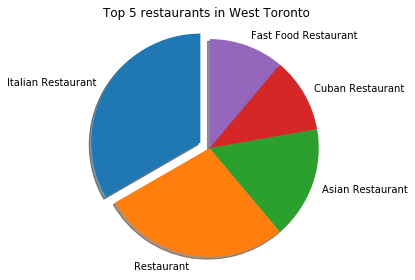

In [207]:
wtoronto_top_5 = pd.DataFrame(toronto_res_sum_group.nlargest(5, 'West Toronto')['West Toronto'])
wtoronto_top_5.reset_index(level=0, inplace=True)
import matplotlib.pyplot as plt

explode = (0.1,0, 0, 0,0)
patches, texts = plt.pie(wtoronto_top_5['West Toronto'],labels=wtoronto_top_5['index'],explode=explode,shadow=True, startangle=90)
plt.axis('equal')
plt.title('Top 5 restaurants in West Toronto')
plt.tight_layout()
plt.show()

### Listing Top 10 common venues in each Borough

In [151]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [153]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = toronto_res_mean_group['Borough']

for ind in np.arange(toronto_res_mean_group.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_res_mean_group.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Borough 1st Most Common Venue 2nd Most Common Venue  \
0   Central Toronto      Sushi Restaurant            Restaurant   
1  Downtown Toronto            Restaurant    Italian Restaurant   
2      East Toronto      Greek Restaurant    Italian Restaurant   
3      West Toronto    Italian Restaurant            Restaurant   

  3rd Most Common Venue 4th Most Common Venue    5th Most Common Venue  \
0     Indian Restaurant    Mexican Restaurant      American Restaurant   
1   Japanese Restaurant   American Restaurant       Seafood Restaurant   
2   American Restaurant  Fast Food Restaurant         Sushi Restaurant   
3      Asian Restaurant      Sushi Restaurant  New American Restaurant   

           6th Most Common Venue          7th Most Common Venue  \
0             Italian Restaurant             Chinese Restaurant   
1                Thai Restaurant  Vegetarian / Vegan Restaurant   
2                     Restaurant           Caribbean Restaurant   
3  Vegetarian / Vegan Restaurant          Vietnamese Restaurant   

  8th Most Common Venue      9th Most Common Venue  \
0  Fast Food Restaurant           Greek Restaurant   
1      Sushi Restaurant         Chinese Restaurant   
2   Japanese Restaurant  Latin American Restaurant   
3      Cuban Restaurant          French Restaurant   

          10th Most Common Venue  
0  Vegetarian / Vegan Restaurant  
1           Fast Food Restaurant  
2      Middle Eastern Restaurant  
3           Fast Food Restaurant

### Cluster Neighborhoods and Examine Clusters

First, let's determine the optimal value of K for our dataset using the Silhouette Coefficient Method

From sklearn documentation - https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

A higher Silhouette Coefficient score relates to a model with better-defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores: `

a: The mean distance between a sample and all other points in the same class.

b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient is for a single sample is then given as:

s=b-a/max(a,b)

Now, to find the optimal value of k for KMeans, loop through 1..n for n_clusters in KMeans and calculate Silhouette Coefficient for each sample.

A higher Silhouette Coefficient indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [274]:
from sklearn.metrics import silhouette_score

toronto_grouped_clustering = toronto_restaurant_grouped.drop('Neighbourhood', 1)
#toronto_grouped_clustering = toronto_grouped_clustering.drop('Total', 1)

for n_cluster in range(2, 10):
    kmeans = KMeans(n_clusters=n_cluster).fit(toronto_grouped_clustering)
    label = kmeans.labels_
    sil_coeff = silhouette_score(toronto_grouped_clustering, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.6500693548796227
For n_clusters=3, The Silhouette Coefficient is 0.5488747040990082
For n_clusters=4, The Silhouette Coefficient is 0.5370416226311662
For n_clusters=5, The Silhouette Coefficient is 0.4992429579304851
For n_clusters=6, The Silhouette Coefficient is 0.4382023795967741
For n_clusters=7, The Silhouette Coefficient is 0.32245934513909236
For n_clusters=8, The Silhouette Coefficient is 0.34237853029873405
For n_clusters=9, The Silhouette Coefficient is 0.3267696171922613


In [275]:
# set number of clusters
kclusters = 2

toronto_grouped_clustering = toronto_restaurant_grouped.drop('Neighbourhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0])

In [277]:
toronto_results = pd.DataFrame(kmeans.cluster_centers_)
toronto_results.columns = toronto_grouped_clustering.columns
toronto_results.index = ['cluster0','cluster1']
# ,'cluster2','cluster3'
toronto_results['Total Sum'] = toronto_results.sum(axis = 1)
toronto_results

Afghan Restaurant  American Restaurant  Argentinian Restaurant  \
cluster0       8.333333e-02             1.833333            8.333333e-02   
cluster1       1.387779e-17             0.192308            1.387779e-17   

          Asian Restaurant  Belgian Restaurant  Brazilian Restaurant  \
cluster0      6.666667e-01            0.166667              0.166667   
cluster1      1.110223e-16            0.038462              0.038462   

          Cajun / Creole Restaurant  Caribbean Restaurant  Chinese Restaurant  \
cluster0                   0.000000              0.416667            0.583333   
cluster1                   0.038462              0.076923            0.192308   

          Colombian Restaurant    ...      Southern / Soul Food Restaurant  \
cluster0          8.333333e-02    ...                         8.333333e-02   
cluster1          1.387779e-17    ...                         1.387779e-17   

          Sushi Restaurant  Taiwanese Restaurant  Tapas Restaurant  \
cluster0          1.000000              0.000000      8.333333e-02   
cluster1          0.346154              0.038462      1.387779e-17   

          Thai Restaurant  Theme Restaurant  Vegetarian / Vegan Restaurant  \
cluster0         1.416667      8.333333e-02                       1.250000   
cluster1         0.153846      1.387779e-17                       0.153846   

          Vietnamese Restaurant      Total  Total Sum  
cluster0               0.666667  24.500000  49.000000  
cluster1               0.038462   4.461538   8.923077  

[2 rows x 51 columns]

In [287]:
toronto_results[['Total','Total Sum']]

Total  Total Sum
cluster0  24.500000  49.000000
cluster1   4.461538   8.923077

__The Total and Total Sum of cluster1 has smallest value. It shows that the market is not saturated.__


In [245]:
toronto_restaurant_grouped['Total'] = toronto_restaurant_grouped.sum(axis=1)

In [278]:
toronto_results_merged = pd.DataFrame(toronto_restaurant_grouped['Neighbourhood'])

toronto_results_merged['Total'] = toronto_restaurant_grouped['Total']
toronto_results_merged = toronto_results_merged.assign(Cluster_Labels = kmeans.labels_)

In [279]:
print(toronto_results_merged.shape)
toronto_results_merged

(38, 3)


Neighbourhood  Total  Cluster_Labels
0                              Adelaide,King,Richmond     29               0
1                                         Berczy Park     11               1
2          Brockton,Exhibition Place,Parkdale Village      3               1
3   Business Reply Mail Processing Centre 969 Eastern      2               1
4   CN Tower,Bathurst Quay,Island airport,Harbourf...      0               1
5                          Cabbagetown,St. James Town     12               1
6                                  Central Bay Street     25               0
7            Chinatown,Grange Park ,Kensington Market     33               0
8                                            Christie      2               1
9                                Church and Wellesley     28               0
10                      Commerce Court,Victoria Hotel     24               0
11                                         Davisville     11               1
12                                   Davisville North      0               1
13  Deer Park,Forest Hill SE,Rathnelly,South Hill,...      3               1
14            Design Exchange,Toronto Dominion Centre     25               0
15                        Dovercourt Village,Dufferin      3               1
16              First Canadian Place,Underground city     24               0
17                 Forest Hill North,Forest Hill West      2               1
18                      Harbord,University of Toronto      9               1
19                          Harbourfront ,Regent Park      5               1
20   Harbourfront East,Toronto Islands,Union Station      14               1
21                       High Park,The Junction South      6               1
22                                      Lawrence Park      0               1
23                  Little Portugal,Trinity–Bellwoods     20               0
24                         Moore Park,Summerhill East      1               1
25                                 North Toronto West      3               1
26                              Parkdale,Roncesvalles      4               1
27                                           Rosedale      0               1
28                                           Roselawn      0               1
29                                  Runnymede,Swansea      9               1
30                            Ryerson,Garden District     24               0
31                                     St. James Town     25               0
32                    Stn A PO Boxes 25 The Esplanade     20               0
33                                    Studio District      9               1
34                  The Annex,North Midtown,Yorkville      4               1
35                                        The Beaches      0               1
36                      The Beaches West,India Bazaar      3               1
37                        The Danforth West,Riverdale     17               0

In [280]:
toronto_merged = toronto_neigh_df
toronto_merged = toronto_merged.drop('Postcode',1)
toronto_merged = toronto_merged.join(toronto_results_merged.set_index('Neighbourhood'), on='Neighbourhood')

print(toronto_merged.shape)
toronto_merged

(38, 6)


Borough                                      Neighbourhood  \
0       East Toronto                                        The Beaches   
1       East Toronto                        The Danforth West,Riverdale   
2       East Toronto                      The Beaches West,India Bazaar   
3       East Toronto                                    Studio District   
4    Central Toronto                                      Lawrence Park   
5    Central Toronto                                   Davisville North   
6    Central Toronto                                 North Toronto West   
7    Central Toronto                                         Davisville   
8    Central Toronto                         Moore Park,Summerhill East   
9    Central Toronto  Deer Park,Forest Hill SE,Rathnelly,South Hill,...   
10  Downtown Toronto                                           Rosedale   
11  Downtown Toronto                         Cabbagetown,St. James Town   
12  Downtown Toronto                               Church and Wellesley   
13  Downtown Toronto                          Harbourfront ,Regent Park   
14  Downtown Toronto                            Ryerson,Garden District   
15  Downtown Toronto                                     St. James Town   
16  Downtown Toronto                                        Berczy Park   
17  Downtown Toronto                                 Central Bay Street   
18  Downtown Toronto                             Adelaide,King,Richmond   
19  Downtown Toronto   Harbourfront East,Toronto Islands,Union Station    
20  Downtown Toronto            Design Exchange,Toronto Dominion Centre   
21  Downtown Toronto                      Commerce Court,Victoria Hotel   
22   Central Toronto                                           Roselawn   
23   Central Toronto                 Forest Hill North,Forest Hill West   
24   Central Toronto                  The Annex,North Midtown,Yorkville   
25  Downtown Toronto                      Harbord,University of Toronto   
26  Downtown Toronto           Chinatown,Grange Park ,Kensington Market   
27  Downtown Toronto  CN Tower,Bathurst Quay,Island airport,Harbourf...   
28  Downtown Toronto                    Stn A PO Boxes 25 The Esplanade   
29  Downtown Toronto              First Canadian Place,Underground city   
30  Downtown Toronto                                           Christie   
31      West Toronto                        Dovercourt Village,Dufferin   
32      West Toronto                  Little Portugal,Trinity–Bellwoods   
33      West Toronto         Brockton,Exhibition Place,Parkdale Village   
34      West Toronto                       High Park,The Junction South   
35      West Toronto                              Parkdale,Roncesvalles   
36      West Toronto                                  Runnymede,Swansea   
37      East Toronto  Business Reply Mail Processing Centre 969 Eastern   

     Latitude  Longitude  Total  Cluster_Labels  
0   43.676357 -79.293031      0               1  
1   43.679557 -79.352188     17               0  
2   43.668999 -79.315572      3               1  
3   43.659526 -79.340923      9               1  
4   43.728020 -79.388790      0               1  
5   43.712751 -79.390197      0               1  
6   43.715383 -79.405678      3               1  
7   43.704324 -79.388790     11               1  
8   43.689574 -79.383160      1               1  
9   43.686412 -79.400049      3               1  
10  43.679563 -79.377529      0               1  
11  43.667967 -79.367675     12               1  
12  43.665860 -79.383160     28               0  
13  43.654260 -79.360636      5               1  
14  43.657162 -79.378937     24               0  
15  43.651494 -79.375418     25               0  
16  43.644771 -79.373306     11               1  
17  43.657952 -79.387383     25               0  
18  43.650571 -79.384568     29               0  
19  43.640816 -79.381752     14               1  
20  43.647177 -79.381576     25      

### Finally, let's visualize the resulting clusters 



In [285]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = ['red','blue']
# ,'green','blue'
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Now Lets examine each cluster

### Cluster 0 : Saturated Market

We can notice from the result and these neighbourhoods in Downtown Toronto has more restaurants.

In [282]:
toronto_merged[toronto_merged['Cluster_Labels'] == 0].reset_index(drop=True)

Borough                             Neighbourhood   Latitude  \
0       East Toronto               The Danforth West,Riverdale  43.679557   
1   Downtown Toronto                      Church and Wellesley  43.665860   
2   Downtown Toronto                   Ryerson,Garden District  43.657162   
3   Downtown Toronto                            St. James Town  43.651494   
4   Downtown Toronto                        Central Bay Street  43.657952   
5   Downtown Toronto                    Adelaide,King,Richmond  43.650571   
6   Downtown Toronto   Design Exchange,Toronto Dominion Centre  43.647177   
7   Downtown Toronto             Commerce Court,Victoria Hotel  43.648198   
8   Downtown Toronto  Chinatown,Grange Park ,Kensington Market  43.653206   
9   Downtown Toronto           Stn A PO Boxes 25 The Esplanade  43.646435   
10  Downtown Toronto     First Canadian Place,Underground city  43.648429   
11      West Toronto         Little Portugal,Trinity–Bellwoods  43.647927   

    Longitude  Total  Cluster_Labels  
0  -79.352188     17               0  
1  -79.383160     28               0  
2  -79.378937     24               0  
3  -79.375418     25               0  
4  -79.387383     25               0  
5  -79.384568     29               0  
6  -79.381576     25               0  
7  -79.379817     24               0  
8  -79.400049     33               0  
9  -79.374846     20               0  
10 -79.382280     24               0  
11 -79.419750     20               0

### Cluster 1 : Untapped Markets

We can notice from the result and these neighbourhoods in Toronto has less or no restaurants. These neighborhoods has a potential for a new restaurant to be successful.

In [283]:
toronto_merged[toronto_merged['Cluster_Labels'] == 1].reset_index(drop=True)

Borough                                      Neighbourhood  \
0       East Toronto                                        The Beaches   
1       East Toronto                      The Beaches West,India Bazaar   
2       East Toronto                                    Studio District   
3    Central Toronto                                      Lawrence Park   
4    Central Toronto                                   Davisville North   
5    Central Toronto                                 North Toronto West   
6    Central Toronto                                         Davisville   
7    Central Toronto                         Moore Park,Summerhill East   
8    Central Toronto  Deer Park,Forest Hill SE,Rathnelly,South Hill,...   
9   Downtown Toronto                                           Rosedale   
10  Downtown Toronto                         Cabbagetown,St. James Town   
11  Downtown Toronto                          Harbourfront ,Regent Park   
12  Downtown Toronto                                        Berczy Park   
13  Downtown Toronto   Harbourfront East,Toronto Islands,Union Station    
14   Central Toronto                                           Roselawn   
15   Central Toronto                 Forest Hill North,Forest Hill West   
16   Central Toronto                  The Annex,North Midtown,Yorkville   
17  Downtown Toronto                      Harbord,University of Toronto   
18  Downtown Toronto  CN Tower,Bathurst Quay,Island airport,Harbourf...   
19  Downtown Toronto                                           Christie   
20      West Toronto                        Dovercourt Village,Dufferin   
21      West Toronto         Brockton,Exhibition Place,Parkdale Village   
22      West Toronto                       High Park,The Junction South   
23      West Toronto                              Parkdale,Roncesvalles   
24      West Toronto                                  Runnymede,Swansea   
25      East Toronto  Business Reply Mail Processing Centre 969 Eastern   

     Latitude  Longitude  Total  Cluster_Labels  
0   43.676357 -79.293031      0               1  
1   43.668999 -79.315572      3               1  
2   43.659526 -79.340923      9               1  
3   43.728020 -79.388790      0               1  
4   43.712751 -79.390197      0               1  
5   43.715383 -79.405678      3               1  
6   43.704324 -79.388790     11               1  
7   43.689574 -79.383160      1               1  
8   43.686412 -79.400049      3               1  
9   43.679563 -79.377529      0               1  
10  43.667967 -79.367675     12               1  
11  43.654260 -79.360636      5               1  
12  43.644771 -79.373306     11               1  
13  43.640816 -79.381752     14               1  
14  43.711695 -79.416936      0               1  
15  43.696948 -79.411307      2               1  
16  43.672710 -79.405678      4               1  
17  43.662696 -79.400049      9               1  
18  43.628947 -79.394420      0               1  
19  43.669542 -79.422564      2               1  
20  43.669005 -79.442259      3               1  
21  43.636847 -79.428191      3               1  
22  43.661608 -79.464763      6               1  
23  43.648960 -79.456325      4               1  
24  43.651571 -79.484450      9               1  
25  43.662744 -79.321558      2               1

### Neighbourhoods in Cluster 1 with no restaurants

Lets identify the neighborhoods in Cluster 1 with no restaurants. Management can review and identify which neighborhood they want to choose to open the new restaurant.

In [284]:
toronto_no_res = toronto_merged[toronto_merged['Cluster_Labels'] == 1].reset_index(drop=True)
toronto_no_res = toronto_no_res[toronto_no_res['Total'] == 0].reset_index(drop=True)
toronto_no_res

Borough                                      Neighbourhood  \
0      East Toronto                                        The Beaches   
1   Central Toronto                                      Lawrence Park   
2   Central Toronto                                   Davisville North   
3  Downtown Toronto                                           Rosedale   
4   Central Toronto                                           Roselawn   
5  Downtown Toronto  CN Tower,Bathurst Quay,Island airport,Harbourf...   

    Latitude  Longitude  Total  Cluster_Labels  
0  43.676357 -79.293031      0               1  
1  43.728020 -79.388790      0               1  
2  43.712751 -79.390197      0               1  
3  43.679563 -79.377529      0               1  
4  43.711695 -79.416936      0               1  
5  43.628947 -79.394420      0               1

### Discussion:

Toronto is a big city with a high population density and with very diverse ethnic and cultural background. Due to diverse culture and people immigrated from multiple countries, Toronto has wide variety of restaurants. We focused on neighborhoods in 4 boroughs – Downtown, East, West and Central Toronto.

We used K-means algorithm as part of this clustering study and identified the optimum K value using Silhouette coefficient as 2. We also identified neighborhoods with no restaurants which shows that there is no nearby competition to begin with. It is possible that there may be reasons for no restaurants in that area which might make them unsuitable for new restaurants. Therefore, these locations can be used as markers/starting points for more detailed local analysis based on other factors.


### Conclusion:

Goal of this project is to identify neighborhoods in the City of Toronto with less or no restaurants in order to aid management in narrowing down the search for optimal location for a new Mediterranean restaurant. Using Foursquare data, we have identified all venues in each neighborhood in the city, filtered the restaurants and grouped them to identify the number of different restaurants in the area. Clustering of those locations was then performed to create zones of interest and later identified the neighborhoods that has no restaurants which will help management to explore possible location for the new restaurant.

Final decision on optimal restaurant location will be made by management based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location such as proximity to major attractions, levels of noise, proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.
